In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
import xarray as xr
import polars as pl
import glob
import torch 
import torch.nn as nn 
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

# Defining our XGBRegressor model to be computed using CPU
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

import time

In [59]:
data_dir = '/home/hawbecker/kaggle/LEAP'

num_locs = 384 # From the test file
total_len = 625000 # size of training set
train_size = 400000 # amount of data from training set we use for training
test_size = total_len - train_size
batch_size = num_locs * 10

train_data_file = os.path.join(data_dir,'train.csv')
test_data_file = os.path.join(data_dir,'test.csv')
submission_file = os.path.join(data_dir,'sample_submission.csv')

## Load model:

In [60]:
model = model_trained = tf.keras.models.load_model('{}/CNN_no_fancy_features.keras'.format(data_dir),compile=False)

In [61]:
proc_data_dir = os.path.join(data_dir,'processed_data')
test_x_files = sorted(glob.glob(os.path.join(proc_data_dir,'test_data_*')))

# TESTING WORKFLOW:

In [62]:
test_x_files = sorted(glob.glob(os.path.join(proc_data_dir,'train_data_X*')))[:50]
test_y_files = sorted(glob.glob(os.path.join(proc_data_dir,'train_data_Y*')))[:50]

# Get ready to submit:

In [63]:
sample_ids = pd.read_csv(submission_file,usecols=[0])

In [64]:
with open(submission_file,'r') as f:
    sub_cols = f.readline().replace('\n','').split(',')[1:]

### Make predictions look like submission file:

In [65]:
y_out_cols = ['ptend_q0001',
              'ptend_q0002',
              'ptend_q0003',
              'ptend_t',
              'ptend_u',
              'ptend_v',
              'cam_out_NETSW',
              'cam_out_FLWDS',
              'cam_out_PRECSC',
              'cam_out_PRECC',
              'cam_out_SOLS',
              'cam_out_SOLL',
              'cam_out_SOLSD',
              'cam_out_SOLLD']

### Files are too big to read in at once... need to iterate:

In [66]:
total_files = len(test_x_files)
n_batches = 10
n_files = int(total_files/n_batches)

file_chunks = np.arange(0,total_files,n_files)
print(file_chunks)

[ 0  5 10 15 20 25 30 35 40 45]


In [67]:
init_df = sample_ids[['sample_id']]

chunk_dfs = {}
for ff,f_s in enumerate(file_chunks[:]):
    f_e = f_s + n_files
    if f_e > total_files: f_e = total_files

    X_test = xr.open_mfdataset(test_x_files[f_s:f_e])    

    # Pre-Processing - Standard Scaling our Cleaned Features
    X_test_scaled = X_test.copy()*1.0
    scaler = StandardScaler()
    for lvl in X_test.level:
        data = X_test.sel(level=lvl).to_array().T
        scaler.fit(data)
        scaled_data = scaler.transform(data)
        for vv,varn in enumerate(list(X_test.data_vars)):
            X_test_scaled[varn].sel(level=lvl).data = scaled_data[:,vv]

    X_test = X_test_scaled.to_array().transpose('point','level','variable')

    del(X_test_scaled)

    #make datasets 
    ds_test = tf.data.Dataset.from_tensor_slices(X_test)

    # Pre-Processing our X_test data and calculating predictions using trained multi_model
    predictions = model.predict(X_test)
    
    for cc,col in enumerate(sub_cols):
        if 'out' not in col:
            ### Things seem off... maybe the columns are inverted?
            lvl = int(col.split('_')[-1])
            varn = '_'.join(col.split('_')[:2])
            var_col = y_out_cols.index(varn)
        else:
            var_col = y_out_cols.index(col)
            lvl = 0
        data = predictions[:,lvl,var_col]
        data_df = pd.DataFrame({col:data},index=np.asarray(X_test.point.data))
        if cc == 0:
            chunk_df = data_df
        else:
            chunk_df = pd.concat([chunk_df,data_df],axis=1)
    chunk_df = pd.concat([init_df,chunk_df],axis=1).dropna()
    
    chunk_dfs[ff] = chunk_df
    if ff == 0:
        full_df = chunk_df
    else:
        full_df = pd.concat([full_df,chunk_df])
print(full_df)


782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
          sample_id     ptend_t_0     ptend_t_1     ptend_t_2     ptend_t_3  \
0       test_169651  23793.259766  40127.851562  40121.367188  40118.042969   
1       test_524862  23944.638672  40340.175781  40334.828125  40330.203125   
2       test_634129  23378.195312  39452.324219  39446.894531  39448.468750   
3       test_403572  23871.771484  40257.980469  40251.167969  40248.121094   
4       test_484578  23881.808594  40220.972656  40216.445312  40210.984375   
...             ...           ...           ...           ...           ...   
249995  test_515652  23429.921875  38

In [15]:
submission = pd.read_csv(submission_file)

In [16]:
data_cols = list(submission.columns[1:])

In [68]:
sample_outs_ds = xr.open_mfdataset(test_y_files[:]) 
sample_outs_df = sample_outs_ds.to_array().transpose('point','level','variable')

In [69]:
for cc,col in enumerate(sub_cols):
    if 'out' not in col:
        ### Things seem off... maybe the columns are inverted?
        lvl = int(col.split('_')[-1])
        varn = '_'.join(col.split('_')[:2])
        var_col = y_out_cols.index(varn)
    else:
        var_col = y_out_cols.index(col)
        lvl = 0
    data = sample_outs_df[:,lvl,var_col]
    out_data_df = pd.DataFrame({col:data},index=np.asarray(sample_outs_ds.point.data))
    if cc == 0:
        sample_out_df = out_data_df
    else:
        sample_out_df = pd.concat([sample_out_df,out_data_df],axis=1)
sample_out_df = pd.concat([init_df,sample_out_df],axis=1).dropna()

In [70]:
sample_out_df.describe()

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,...,2.500000e+05,2.500000e+05,250000.000000,250000.000000,2.500000e+05,2.500000e+05,2.500000e+05,2.500000e+05,250000.000000,250000.000000
mean,0.000008,-0.000012,-0.000005,-0.000001,-0.000002,-6.495539e-07,1.398732e-07,3.662977e-07,-3.717416e-08,-1.521849e-07,...,-1.359739e-07,-1.414859e-06,163.102262,343.580337,3.119625e-09,2.912592e-08,6.363486e+01,6.953569e+01,33.980342,18.125852
std,0.000029,0.000041,0.000049,0.000067,0.000092,1.137538e-04,1.075512e-04,8.234488e-05,5.275096e-05,4.046312e-05,...,2.257012e-05,3.091700e-05,254.246519,75.747765,7.711158e-09,8.142252e-08,1.135401e+02,1.196832e+02,45.997230,29.642123
min,-0.000291,-0.001921,-0.000238,-0.000253,-0.000206,-1.947830e-04,-1.911773e-04,-1.762502e-04,-1.220218e-04,-9.489841e-05,...,-3.906534e-04,-7.709305e-04,0.000000,85.516510,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,-0.000015,-0.000045,-0.000047,-0.000062,-0.000086,-1.011243e-04,-9.044616e-05,-6.852935e-05,-4.464027e-05,-3.479605e-05,...,-6.109186e-06,-1.060323e-05,0.000000,301.035385,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000003,-0.000014,-0.000017,-0.000034,-0.000059,-6.512160e-05,-5.538074e-05,-4.117409e-05,-2.623414e-05,-1.911800e-05,...,2.687678e-09,-7.761189e-08,0.031516,357.620895,0.000000e+00,3.992896e-09,1.530027e-17,2.585331e-15,0.970724,0.819093
75%,0.000036,0.000022,0.000043,0.000069,0.000100,1.227307e-04,1.001094e-04,7.078690e-05,4.490099e-05,3.411137e-05,...,6.954214e-06,8.917837e-06,254.743420,406.311424,1.661695e-09,1.949871e-08,7.830611e+01,9.504564e+01,60.449620,26.307206
max,0.003630,0.000320,0.000107,0.000130,0.000159,2.319099e-04,2.619764e-04,2.271380e-04,1.578918e-04,1.305386e-04,...,3.228377e-04,4.303816e-04,1075.131226,475.335602,1.693544e-07,1.540775e-06,5.184690e+02,5.547748e+02,316.410339,232.878708


In [71]:
full_df.describe()

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000,2.500000e+05,2.500000e+05,250000.000000,250000.000000
mean,23816.671875,39259.933594,39259.328125,39257.054688,39254.285156,39252.175781,39251.296875,39250.871094,39250.914062,39251.457031,...,-7677.354004,-2096.449951,2.763429e+06,707878.375000,-2367.931641,328.973785,1.550778e+06,1.529607e+06,-236795.484375,-270804.718750
std,1248.711304,1749.052124,1749.093140,1749.031738,1748.961060,1748.882812,1748.930176,1749.093872,1749.203125,1749.220337,...,569.984802,200.669937,1.379676e+05,32908.953125,171.990280,317.480377,7.571007e+04,7.529273e+04,12317.195312,12059.003906
min,17605.626953,29416.207031,29416.550781,29416.021484,29415.494141,29414.800781,29413.263672,29411.535156,29410.847656,29411.607422,...,-8967.583008,-2354.248779,2.013277e+06,516442.468750,-2627.031494,-707.277649,1.131451e+06,1.115099e+06,-254619.562500,-286818.531250
25%,23333.202637,38814.975586,38814.493164,38812.470703,38810.281250,38808.318359,38807.574219,38807.179688,38806.915039,38807.438477,...,-8145.896729,-2279.298584,2.717188e+06,698634.265625,-2521.189697,87.989655,1.526543e+06,1.505072e+06,-246665.570312,-278518.046875
50%,23846.882812,39845.476562,39844.761719,39842.203125,39839.347656,39837.189453,39836.226562,39835.982422,39836.210938,39836.636719,...,-7802.212158,-2152.999756,2.780336e+06,714716.093750,-2405.881348,511.532471,1.562724e+06,1.540789e+06,-239116.921875,-273884.468750
75%,24544.558594,40306.790039,40306.215820,40304.021484,40301.040039,40298.757812,40297.832031,40297.558594,40297.687500,40298.231445,...,-7313.067017,-1928.022797,2.837672e+06,729600.687500,-2238.198364,575.873108,1.591123e+06,1.569651e+06,-230615.324219,-267832.218750
max,26689.955078,42173.425781,42162.234375,42159.882812,42153.316406,42152.000000,42153.640625,42155.265625,42154.957031,42154.003906,...,-5047.339844,-1336.347412,3.013737e+06,751070.375000,-1628.553345,734.391479,1.683477e+06,1.662826e+06,-173987.000000,-201012.171875


In [17]:
# Using the submission sample target values as weights 
submission.loc[:,data_cols] *= full_df.loc[:,data_cols]
#submission.loc[:, y_fixed_columns] *= np.mean(y_fixed.to_numpy(), axis=0)

KeyError: "['ptend_t_0'] not in index"

In [35]:
# Outputting our submission file
file_name = 'leap_sub_'

existing_subs = sorted(glob.glob(os.path.join('./submissions','{}*.csv'.format(file_name))))
if existing_subs != []:
    last_sub = int(existing_subs[-1].split('_')[-1].replace('.csv',''))
else:
    last_sub = 0
    
new_sub = last_sub + 1
 
sub_file = os.path.join('./submissions','{0}{1:04d}.csv'.format(file_name,new_sub))
test_polars = pl.from_pandas(submission)
test_polars.write_csv(sub_file)

In [24]:
full_df.ptend_u_59.mean()

-19.775724

In [23]:
submission.ptend_u_59.mean()

19133.428743715143

In [36]:
existing_subs = sorted(glob.glob(os.path.join('./submissions','{}*.csv'.format(file_name))))
print(existing_subs)

['./submissions/leap_sub_0002.csv', './submissions/leap_sub_1.csv']


In [59]:
sub1 = pd.read_csv(existing_subs[1],nrows=1000)

In [60]:
sub2 = pd.read_csv(existing_subs[0],nrows=1000)

In [75]:
sub2.describe()

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,-142108.227333,27586.672339,23712.174153,18621.581191,14298.220067,11968.690775,12773.866496,16637.010576,25802.530979,33215.669123,...,6952.150222,285077.221808,0.730134,5.376149,-2.027081e+09,-2.100664e+08,0.830304,0.797815,0.597985,0.785636
std,134848.874886,12126.394673,10307.472527,8103.084859,6255.111874,5245.327724,5588.051495,7256.842632,11224.335028,14410.490227,...,15155.233986,63169.257138,0.847590,0.490915,7.093798e+08,3.010176e+07,0.834372,0.883561,0.683084,0.539654
min,-544073.370642,707.725886,918.688907,649.210707,837.616399,1197.343931,1642.670682,2242.142909,3479.061045,4005.182754,...,-133726.686948,83115.228250,0.103181,3.433014,-3.530955e+09,-2.892644e+08,0.148329,0.139198,-0.068386,-0.218913
25%,-158680.817809,21559.602090,18442.575845,14487.903234,11028.656691,9218.384221,9844.108965,12842.719422,20079.134175,25875.553228,...,3851.940512,244528.439682,0.132869,5.093212,-2.383046e+09,-2.221514e+08,0.218724,0.175032,0.076389,0.375639
50%,-117558.517971,25189.074515,21666.906638,16935.485798,13016.952720,10896.096077,11658.816892,15196.963690,23653.743463,30465.511434,...,11235.121832,299241.981265,0.139597,5.455455,-2.105632e+09,-2.153381e+08,0.251448,0.196568,0.139346,0.527286
75%,-83583.000066,27536.690323,23667.150196,18529.996112,14190.740303,11921.914701,12800.104436,16700.141701,25932.160808,33369.047729,...,14408.206157,337074.871999,1.352975,5.728035,-1.783404e+09,-2.039985e+08,1.473556,1.442183,1.192851,1.197685
max,264807.183716,70423.522359,59440.651792,46037.556870,35239.089372,29682.103649,31743.066199,41436.962569,64197.721118,82750.053436,...,35992.561824,402884.731441,3.146508,6.635817,7.619493e+08,1.480416e+08,3.489348,3.152709,2.215634,2.038030


In [74]:
sub1.describe()

,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.294172,-0.290672,-0.085328,-0.068576,-0.047989,-0.014062,-0.006061,-0.004573,0.001317,0.001115,...,-2.230551e-02,-0.083412,0.692078,4.867213,4.387006e-01,3.831565e-01,0.613033,0.625506,0.704709,0.590341
std,0.407580,0.436592,0.578611,0.686824,0.818138,0.876053,0.859429,0.801135,0.687537,0.589560,...,6.942366e-18,0.149834,1.035430,1.022383,5.553893e-17,1.110779e-16,1.010879,1.007807,0.912433,0.848726
min,-0.094976,-0.891434,-0.939500,-0.713883,-0.789991,-0.770786,-0.714753,-0.658181,-0.546684,-0.486214,...,-2.230551e-02,-0.264932,-0.074717,1.834383,4.387006e-01,3.831565e-01,-0.109081,-0.111161,-0.103152,-0.161964
25%,-0.094976,-0.607232,-0.601501,-0.713883,-0.789991,-0.770786,-0.714753,-0.658181,-0.546684,-0.486214,...,-2.230551e-02,-0.264932,-0.001198,4.303665,4.387006e-01,3.831565e-01,-0.000056,-0.001231,-0.003772,0.005436
50%,-0.094976,-0.607232,-0.601501,-0.713883,-0.789991,-0.616193,-0.556437,-0.489949,-0.546684,-0.486214,...,-2.230551e-02,0.040144,0.032691,5.123979,4.387006e-01,3.831565e-01,0.047156,0.043477,0.075452,0.106440
75%,0.727804,0.196557,0.535370,0.703958,0.969019,1.137906,0.786643,0.877005,0.789841,0.841217,...,-2.230551e-02,0.040144,1.208377,5.667698,4.387006e-01,3.831565e-01,0.861830,0.898663,1.386066,0.928583
max,0.727804,0.196557,0.535370,0.703958,0.969019,1.261325,1.454143,1.408423,1.092982,0.841217,...,-2.230551e-02,0.040144,3.826706,6.252078,4.387006e-01,3.831565e-01,4.364624,4.249082,4.488042,3.883669


<Axes: >

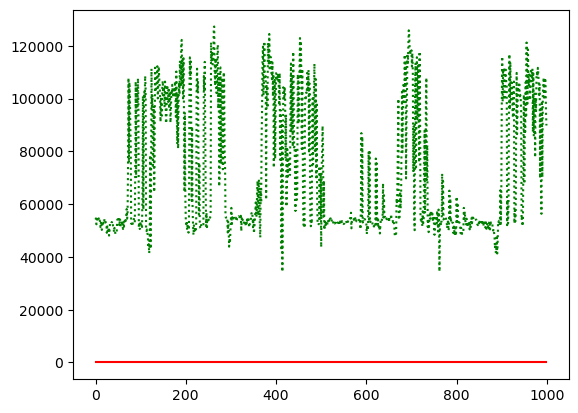

In [62]:
sub1.ptend_u_50.plot(c='r')
sub2.ptend_u_50.plot(c='g',ls=':')